In [161]:
from PIL import Image
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision.transforms import Compose, ToTensor

plt.style.use("dark_background")

In [135]:
def rgb_to_hexint_image(rgb_image):
    """
    Converts an RGB image (H, W, 3) to a 2D image (H, W) with integer hex values.
    Example: [255, 0, 170] → 0xFF00AA → 16711850
    """
    r = rgb_image[:, :, 0].astype(np.uint32)
    g = rgb_image[:, :, 1].astype(np.uint32)
    b = rgb_image[:, :, 2].astype(np.uint32)
    hexint_image = (r << 16) + (g << 8) + b
    return hexint_image


def hexint_to_rgb_image(hexint_image):
    """
    Converts a 2D image (H, W) with integer hex values back to an RGB image (H, W, 3).
    Example: 16711850 → [255, 0, 170]
    """
    r = (hexint_image >> 16) & 0xFF
    g = (hexint_image >> 8) & 0xFF
    b = hexint_image & 0xFF
    rgb_image = np.stack([r, g, b], axis=-1).astype(np.uint8)
    return rgb_image

In [136]:

current_dir = Path(".")

zeros_files = list(current_dir.glob("data/0/*"))
ones_files = list(current_dir.glob("data/1/*"))

zeros_labels = torch.zeros((len(zeros_files), 1))
ones_labels = torch.ones((len(ones_files), 1))

x = zeros_files + ones_files
y = torch.vstack([zeros_labels, ones_labels])

In [137]:
HEIGHT, WIDTH, CHANNELS = DIMENSION = (100, 100, 3)

transform = Compose([
    Image.open,
    np.array,
    rgb_to_hexint_image,
    ToTensor(),
    torch.flatten,
    lambda t: t.float(),
])

In [150]:
def de_transform(t):
    a = t.numpy().astype(np.uint)
    a = a.reshape(HEIGHT, WIDTH)
    a = hexint_to_rgb_image(a)
    img = Image.fromarray(a)
    return img

In [139]:
class MyDataset(Dataset):
    def __init__(self, x, y, transform):
        self.x = x
        self.y = y
        self.length = len(x)
        self.transform = transform
    
    def __getitem__(self, index):
        return (
            self.transform(self.x[index]),
            self.y[index],
        )
    
    def __len__(self):
        return self.length

In [140]:
class Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        self.l1 = nn.Linear(input_size, input_size)
        self.l2 = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        output = self.l1(x)
        output = torch.abs(output)
        output = self.l2(output)
        output = self.sigmoid(output)
        return output
    
    def layering(self, x):
        with torch.no_grad():
            output = self.l1(x)
            output = torch.abs(output)
            return output

In [141]:
dataset = MyDataset(x, y, transform)
dataloader = DataLoader(dataset, shuffle=False)

In [144]:
input_size = dataset[0][0].shape[0]
model = Model(input_size)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

losses = []
epochs = 1

for epoch in range(1, epochs + 1):
    model.train()
    for x_batch, y_batch in dataloader:
        output = model.forward(x_batch)
        loss = criterion(output, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
    if epoch % 1 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/1], Loss: 0.0000


In [159]:
y_pred = model(dataset[150][0]).detach()

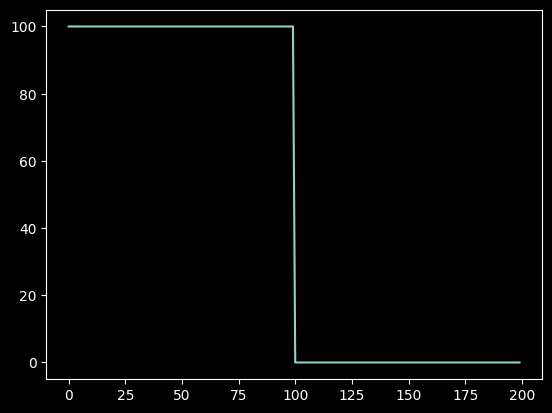

In [162]:
plt.plot(losses)